# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [28]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [7]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           use_unigram_document_model=False,
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [8]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [9]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

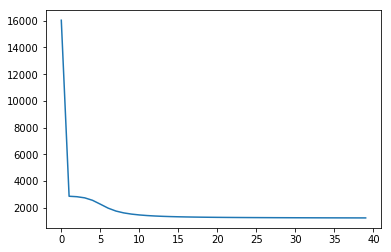

In [10]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [11]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они также семья это являться как для свой мочь
sbj1:  что свой который быть это герой его этот человек они она ребенок как жизнь такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение это быть свой этот звук год весь его лирика такой
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть это как политический себя государство век культура жизнь для
sbj8:  страна государство который население быть территория этот год являться сша что время африка хозяйство также
sbj9:  быть который год государство война свой что становиться первый как весь время империя армия военный


Давайте посмотрим также на разреженность матриц:

In [12]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.75459345301
0.106092436975


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [13]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [14]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [15]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они семья также это являться для свой время русский
sbj1:  что свой который быть это герой человек его этот она жизнь они ребенок как такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение быть свой это звук этот год весь его лирика произведение
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть как это политический государство себя культура жизнь век для
sbj8:  страна государство население который быть территория этот год являться африка время что хозяйство также сша
sbj9:  быть который год государство война свой что становиться первый как весь военный время империя армия


In [16]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.801751661594
0.285084033613


Попробуем менять коэффициент регуляризации:

In [17]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [18]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [19]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право язык свобода семья гражданин английский правовой религиозный гражданский суд порядок орган честь will is
sbj1:  ребенок поэма лермонтов сказка отец молодой хороший сюжет любить гоголь комедия ничто романтизм жена эпос
sbj2:  слово предложение например случай работа простой предмет какой речь глагол физика скорость свет кто угол
sbj3:  земля энергия вода ядро масса количество природный океан атом движение температура частица заряд море располагать
sbj4:  пушкин поэт стихотворение звук лирика писать стих поэзия русь былина почти любовный князь бумага сравнение
sbj5:  x при a число если b функция тело два получать можно уравнение равный пример корень
sbj6:  человек свой его жизнь герой русский произведение мир литература история сам автор литературный личность писатель
sbj7:  общество век развитие социальный политический отношение процесс форма экономический производство культура характер система понятие роль
sbj8:  государство страна территория население город северный миров

In [20]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.900080750357
0.331512605042


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [21]:
model_artm.save("my_model")

In [30]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [34]:
phi = model_artm.get_phi()

In [35]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
переговоры,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000527
близ,0.0,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
тридцать,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
припасы,0.0,0.000000,0.000000,0.000000,0.000257,0.000000,0.000000,0.000000,0.000000,0.000000
некто,0.0,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
неповторимость,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000
Софийска,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000000
оседлый,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000198
класс,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003879,0.000000,0.000000
женщина,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Матрица вероятностей тем в документах.

In [38]:
theta = model_artm.get_theta()
theta

""


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [26]:
theta_test = model_artm.transform(batch_vectorizer)